In [ ]:
# Functional Autoencoder in PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F


class FourierBasis(nn.Module):
    """
    Simple Fourier basis on [0, 1] for representing functional weights.
    """
    def __init__(self, num_basis: int, T: int, device=None, dtype=torch.float32):
        super().__init__()
        self.num_basis = num_basis
        self.T = T
        device = device or torch.device("cpu")

        # time grid in [0, 1]
        t = torch.linspace(0.0, 1.0, T, dtype=dtype, device=device)  # [T]
        self.register_buffer("t", t)

        # Build basis matrix Phi[b, t] = phi_b(t)
        # basis 0: constant; others: sines and cosines
        Phi = torch.zeros(num_basis, T, dtype=dtype, device=device)
        Phi[0] = 1.0
        k = 1
        freq = 1
        while k < num_basis:
            Phi[k] = torch.sin(2 * torch.pi * freq * t)
            k += 1
            if k < num_basis:
                Phi[k] = torch.cos(2 * torch.pi * freq * t)
                k += 1
            freq += 1

        self.register_buffer("Phi", Phi)

        # approximate dt for Riemann sum
        dt = (t[-1] - t[0]) / (T - 1)
        self.register_buffer("dt", torch.tensor(dt, dtype=dtype, device=device))


class FunctionalAutoencoder(nn.Module):
    """
    Functional Autoencoder (FAE) for P-dimensional functional data.

    x: [batch, P, T]  (P channels, T time points)
    latent_dim: dimension d of encoding.
    """
    def __init__(
        self,
        P: int,
        T: int,
        latent_dim: int,
        num_basis: int = 16,
        hidden_dims=None,
        device=None,
        dtype=torch.float32,
    ):
        super().__init__()
        device = device or torch.device("cpu")
        self.P = P
        self.T = T
        self.latent_dim = latent_dim

        # Basis to represent functional weights
        self.basis = FourierBasis(num_basis=num_basis, T=T, device=device, dtype=dtype)

        B = num_basis

        ### Encoder: Functional first layer: HP -> R^H1 ### 
        # coefficients for w^{(1)}_{k,j}(t): shape [H1, P, B]
        H1 = hidden_dims[0] if hidden_dims is not None else latent_dim
        self.w1_coeffs = nn.Parameter(
            torch.randn(H1, P, B, dtype=dtype, device=device) * 0.1
        )

        # Extra hidden layers: optional vector-to-vector hidden layers (between functional first layer and latent)
        fc_layers = []
        in_dim = H1
        if hidden_dims is not None and len(hidden_dims) > 1:
            for h in hidden_dims[1:]:
                fc_layers.append(nn.Linear(in_dim, h, bias=True))
                fc_layers.append(nn.Tanh())
                in_dim = h
        # final linear to latent representation
        fc_layers.append(nn.Linear(in_dim, latent_dim, bias=True))
        self.encoder_mlp = nn.Sequential(*fc_layers)

        ### Decoder: Functional last layer: R^latent -> HP ###
        # coefficients for w^{(last)}_{j,k}(t): shape [P, latent_dim, B]
        self.w_last_coeffs = nn.Parameter(
            torch.randn(P, latent_dim, B, dtype=dtype, device=device) * 0.1
        )

        self.activation = torch.tanh  # can be ReLU / etc.

    # Build functional weights on the time grid (as a helper)
    def _weights_from_coeffs(self, coeffs):
        """
        coeffs: [..., B]
        basis.Phi: [B, T]
        returns: [..., T]
        """
        # Einstein summation: (..., B) * (B, T) -> (..., T)
        return torch.einsum("...b,bt->...t", coeffs, self.basis.Phi)

    ## encoder functional layer ##
    def _encode_first_layer(self, x):
        """
        x: [B, P, T]
        returns hidden_1: [B, H1]
        """
        Bbatch = x.shape[0]
        dt = self.basis.dt

        # w1_funcs: [H1, P, T]
        w1_funcs = self._weights_from_coeffs(self.w1_coeffs)

        # inner product <x_j, w_{k,j}>_L2  ≈ Σ_t x_j(t) w_{k,j}(t) dt
        # x -> [B, 1, P, T]
        # w1_funcs -> [1, H1, P, T]
        prod = x.unsqueeze(1) * w1_funcs.unsqueeze(0)  # [B, H1, P, T]
        inner_per_channel = prod.sum(dim=-1) * dt      # [B, H1, P]

        # sum over P dimensions
        h_raw = inner_per_channel.sum(dim=-1)  # [B, H1]

        h = self.activation(h_raw)
        return h

    ## decoder functional layer ##
    def _decode_last_layer(self, z):
        """
        z: [B, latent_dim]
        returns x_hat: [B, P, T]
        """
        # w_last_funcs: [P, latent_dim, T]
        w_last_funcs = self._weights_from_coeffs(self.w_last_coeffs)

        # x_hat_j(t) = Σ_k z_k * w_{j,k}(t)
        # z: [B, K], w_last_funcs: [P, K, T] -> [B, P, T]
        x_hat = torch.einsum("bk,pkt->bpt", z, w_last_funcs)
        return x_hat

    ## full forward pass ##
    def encode(self, x):
        """
        x: [batch, P, T]
        returns z: [batch, latent_dim]
        """
        h1 = self._encode_first_layer(x)
        z = self.encoder_mlp(h1)
        return z

    def decode(self, z):
        return self._decode_last_layer(z)

    def forward(self, x):
        z = self.encode(x)
        x_hat = self.decode(z)
        return x_hat, z


def functional_mse_loss(x, x_hat, dt):
    """
    Approximate functional L2 reconstruction loss:
    (1 / 2n) sum_i sum_j ∫ (x - x_hat)^2 dt
    x, x_hat: [B, P, T]
    """
    diff2 = (x - x_hat) ** 2  # [B, P, T]
    # integrate over t
    integral = diff2.sum(dim=-1) * dt  # [B, P]
    loss = 0.5 * integral.mean()       # average over batch and P
    return loss


In [ ]:
# Example training loop
import torch
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Simulating the data 
n_samples = 256
P = 3        # number of functional dimensions
T = 100      # number of time points
X_train = torch.randn(n_samples, P, T).to(device)

dataset = TensorDataset(X_train)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Building the model 
latent_dim = 10
num_basis = 16
hidden_dims = [32, 32]   # first is size of functional hidden layer

model = FunctionalAutoencoder(
    P=P,
    T=T,
    latent_dim=latent_dim,
    num_basis=num_basis,
    hidden_dims=hidden_dims,
    device=device,
).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

dt = model.basis.dt

# Training 
for epoch in range(50):
    total_loss = 0.0
    for (batch_x,) in loader:
        batch_x = batch_x.to(device)

        x_hat, z = model(batch_x)
        loss = functional_mse_loss(batch_x, x_hat, dt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_x.size(0)

    avg_loss = total_loss / len(dataset)
    print(f"Epoch {epoch:03d} | loss = {avg_loss:.6f}")

# After training, get embeddings
with torch.no_grad():
    embeddings = model.encode(X_train)    # [n_samples, latent_dim]


C:\Users\PC\AppData\Local\Temp\ipykernel_22996\1076632845.py:39: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.register_buffer("dt", torch.tensor(dt, dtype=dtype, device=device))


Epoch 000 | loss = 0.504705
Epoch 001 | loss = 0.502883
Epoch 002 | loss = 0.501861
Epoch 003 | loss = 0.501079
Epoch 004 | loss = 0.500367
Epoch 005 | loss = 0.499623
Epoch 006 | loss = 0.498738
Epoch 007 | loss = 0.497776
Epoch 008 | loss = 0.496709
Epoch 009 | loss = 0.495659
Epoch 010 | loss = 0.494602
Epoch 011 | loss = 0.493555
Epoch 012 | loss = 0.492508
Epoch 013 | loss = 0.491473
Epoch 014 | loss = 0.490453
Epoch 015 | loss = 0.489507
Epoch 016 | loss = 0.488660
Epoch 017 | loss = 0.487907
Epoch 018 | loss = 0.487231
Epoch 019 | loss = 0.486585
Epoch 020 | loss = 0.485986
Epoch 021 | loss = 0.485442
Epoch 022 | loss = 0.484903
Epoch 023 | loss = 0.484386
Epoch 024 | loss = 0.483892
Epoch 025 | loss = 0.483384
Epoch 026 | loss = 0.482907
Epoch 027 | loss = 0.482462
Epoch 028 | loss = 0.482042
Epoch 029 | loss = 0.481676
Epoch 030 | loss = 0.481313
Epoch 031 | loss = 0.480959
Epoch 032 | loss = 0.480634
Epoch 033 | loss = 0.480327
Epoch 034 | loss = 0.480057
Epoch 035 | loss = 0

In [ ]:
X_train

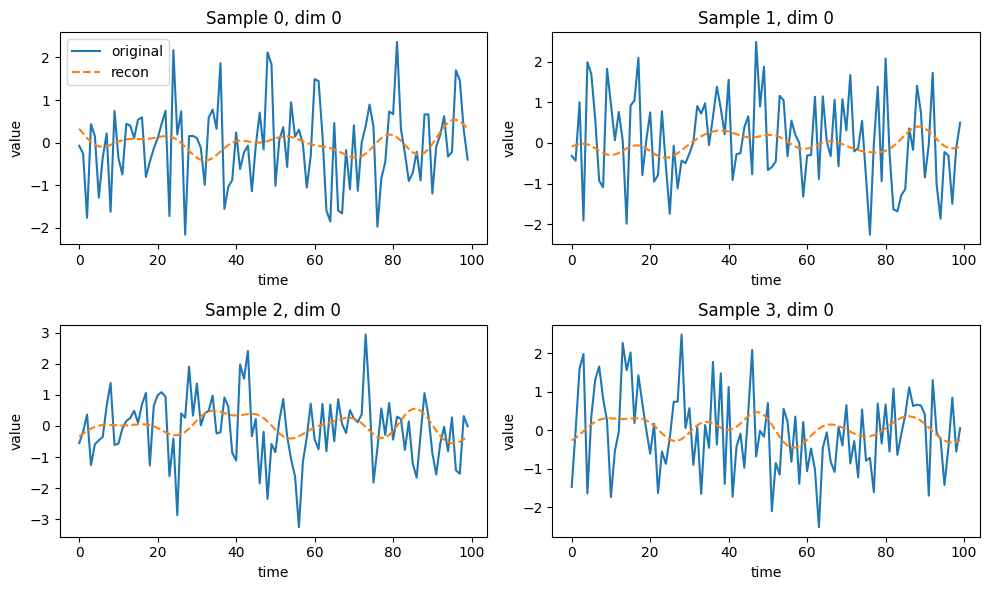

In [ ]:
# Visualization: Reconstruction vs original curves
import matplotlib.pyplot as plt
import torch

model.eval()
with torch.no_grad():
    x = X_train[:8]  # first 8 examples
    x_hat, z = model(x.to(device))
    x_hat = x_hat.cpu()

# assume time grid is implicit 0..T-1
t = torch.arange(T)

n_examples_to_plot = 4
func_dim_to_plot = 0   # pick dimension 0 for illustration

plt.figure(figsize=(10, 6))
for i in range(n_examples_to_plot):
    plt.subplot(2, 2, i + 1)
    plt.plot(t, x[i, func_dim_to_plot].cpu().numpy(), label="original")
    plt.plot(t, x_hat[i, func_dim_to_plot].numpy(), linestyle="--", label="recon")
    plt.title(f"Sample {i}, dim {func_dim_to_plot}")
    plt.xlabel("time")
    plt.ylabel("value")
    if i == 0:
        plt.legend()

plt.tight_layout()
plt.show()


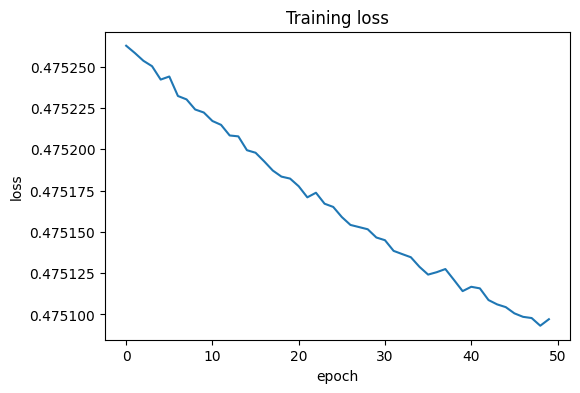

In [12]:
train_losses = []

for epoch in range(50):
    total_loss = 0.0
    for (batch_x,) in loader:
        batch_x = batch_x.to(device)

        x_hat, z = model(batch_x)
        loss = functional_mse_loss(batch_x, x_hat, dt)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * batch_x.size(0)

    avg_loss = total_loss / len(dataset)
    train_losses.append(avg_loss)
    #print(f"Epoch {epoch:03d} | loss = {avg_loss:.6f}")

plt.figure(figsize=(6, 4))
plt.plot(train_losses)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Training loss")
plt.show()



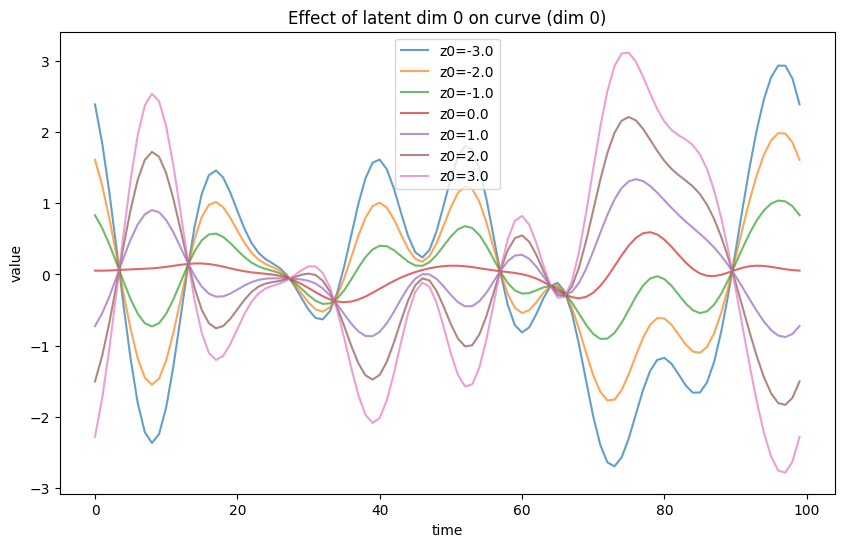

In [10]:
model.eval()
with torch.no_grad():
    x0 = X_train[0:1].to(device)  # [1, P, T]
    z0 = model.encode(x0)         # [1, latent_dim]

z0 = z0[0]  # [latent_dim]

num_points = 7
dim_to_vary = 0
values = torch.linspace(-3, 3, num_points)

decoded_list = []
with torch.no_grad():
    for v in values:
        z_mod = z0.clone()
        z_mod[dim_to_vary] = v
        x_dec = model.decode(z_mod.unsqueeze(0))  # [1, P, T]
        decoded_list.append(x_dec[0].cpu())

decoded = torch.stack(decoded_list, dim=0)  # [num_points, P, T]
t = torch.arange(T)

plt.figure(figsize=(10, 6))
func_dim_to_plot = 0
for i in range(num_points):
    plt.plot(t, decoded[i, func_dim_to_plot].numpy(), label=f"z{dim_to_vary}={values[i]:.1f}", alpha=0.7)

plt.xlabel("time")
plt.ylabel("value")
plt.title(f"Effect of latent dim {dim_to_vary} on curve (dim {func_dim_to_plot})")
plt.legend()
plt.show()
